In [ ]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/CSE256/FinalProject/

/content/drive/MyDrive/CSE256/FinalProject


In [ ]:
!git clone --recursive https://github.com/naigamshah/SelectivePrediction.git

fatal: destination path 'SelectivePrediction' already exists and is not an empty directory.


In [ ]:
!ls

bert_test_squad_hotpot_hotpot.csv    bert_val_squad_natural_hotpot.csv
bert_test_squad_natural_hotpot.csv   bert_val_squad_news_hotpot.csv
bert_test_squad_news_hotpot.csv      bert_val_squad_trivia_hotpot.csv
bert_test_squad_trivia_hotpot.csv    CalibData
bert_train_squad_hotpot_hotpot.csv   data
bert_train_squad_natural_hotpot.csv  plots
bert_train_squad_news_hotpot.csv     SelectivePrediction
bert_train_squad_trivia_hotpot.csv   temp.csv
bert_val_squad_hotpot_hotpot.csv     temp.jsonl


In [ ]:
import torch
import pandas as pd
from torch.utils.data import Dataset
from transformers import AutoModelForQuestionAnswering, AutoTokenizer
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset, concatenate_datasets
from transformers import BertTokenizer, BertModel
import ast
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score, roc_curve, auc
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

In [ ]:
RANDOM_SEED = 7
SRC_PREFIX = "squad"
KNOWN_PREFIX = "natural"
UNKNOWN_PREFIX = "hotpot"

In [ ]:
def load(data_prefix, n):
  if data_prefix=="squad":
    return pd.read_csv("data/squad/train.csv")[["context","question","answers"]].sample(n=n, random_state=RANDOM_SEED).reset_index(drop=True)
  elif data_prefix=="hotpot":
    df = pd.read_csv("data/hotpot_qa/train.csv")[["context","question","answer"]].sample(n=n, random_state=RANDOM_SEED).reset_index(drop=True)
    df.columns = ["context","question","answers"]
    return df
  elif data_prefix=="natural":
    return pd.read_csv("data/natural_questions/train.csv")[["context","question","answers"]].sample(n=n, random_state=RANDOM_SEED).reset_index(drop=True)
  elif data_prefix=="news":
    return pd.read_csv("data/news_qa/train.csv")[["context","question","answers"]].sample(n=n, random_state=RANDOM_SEED).reset_index(drop=True)
  if data_prefix=="trivia":
    return pd.read_csv("data/trivia_qa/unmodified.csv")[["context","question","answers"]].sample(n=n, random_state=RANDOM_SEED).reset_index(drop=True)

In [ ]:
p_src = load(SRC_PREFIX, 6000)
q_known = load(KNOWN_PREFIX, 2000)
q_unknown = load(UNKNOWN_PREFIX, 4000)

In [ ]:
train = pd.concat([p_src.iloc[:1600],q_known.iloc[:1600]]).reset_index(drop=True)
val = pd.concat([p_src.iloc[1600:2000],q_known.iloc[1600:2000]]).reset_index(drop=True)
test = pd.concat([p_src.iloc[2000:6000],q_unknown.iloc[:4000]]).reset_index(drop=True)

In [ ]:
def get_ground_answers(dataset):
  ground_answers = []
  for i in tqdm(range(len(dataset))):
    answer = dataset.iloc[i]["answers"]

    if len(answer)==0:
      ground_answers.append(answer)
      continue

    if answer[0]=='{':
      answer = ast.literal_eval(answer)
      ground_answers.append(answer["text"][0].lower())
    elif answer[0]=='[':
      answer = ast.literal_eval(answer)
      ground_answers.append(answer[0].lower())
    else:
      ground_answers.append(answer.lower())

  return ground_answers

In [ ]:
train["ground_answers"] = get_ground_answers(train)
val["ground_answers"] = get_ground_answers(val)
test["ground_answers"] = get_ground_answers(test)

100%|██████████| 8000/8000 [00:00<00:00, 11631.29it/s]


In [ ]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("deepset/roberta-base-squad2")
model = AutoModelForQuestionAnswering.from_pretrained("deepset/roberta-base-squad2").cuda()

In [ ]:
train

,context,question,answers,ground_answers
0,"It is estimated that in 480 BC, 50 million peo...",The Achaemenid Empire was the known enemy of w...,"{'text': ['the Greek city states'], 'answer_st...",the greek city states
1,In 2004 he was admitted as knight of the Légio...,Who made Spielberg a knight?,"{'text': ['Jacques Chirac'], 'answer_start': [...",jacques chirac
2,KU Endowment was established in 1891 as Americ...,When was the KU Endowment founded?,"{'text': ['1891'], 'answer_start': [32]}",1891
3,2010s saw multiple new sounds in house music d...,Big room house has found increasing popularity...,"{'text': ['2010'], 'answer_start': [1165]}",2010
4,"Much of Yale University's staff, including mos...",What union are Yale's service and maintenance ...,{'text': ['Local 35 of the same international'...,local 35 of the same international
...,...,...,...,...
3195,"<P> Halley 's Comet or Comet Halley , official...",when is halley 's comet predicted to be near e...,['mid-2061'],mid-2061
3196,<Table> <Tr> <Th> 2015 Rank </Th> <Th> City </...,what is the second largest city in idaho,['Meridian'],meridian
3197,<P> Shielding gases are inert or semi-inert ga...,what is the purpose of argon gas in mig welding,"['to protect the weld area from oxygen , and w...","to protect the weld area from oxygen , and wat..."
3198,<P> Dane William DeHaan ( / dəˈhɑːn / də - HAH...,who plays harry in the amazing spider man,['Dane William DeHaan'],dane william dehaan


In [ ]:
def get_calib_data(data):
  predicted_answers = []
  context_question_lens = []
  answer_lens = []
  start_probs_list = []
  end_probs_list = []
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.eval()

  for i in tqdm(range(len(data))):
    question, context = data.iloc[i]["question"], data.iloc[i]["context"]

    inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt", truncation = True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    input_ids = inputs["input_ids"].tolist()[0]

    with torch.no_grad():
      outputs = model(**inputs)

    start_scores = torch.softmax(outputs.start_logits, dim=1).cuda()
    end_scores = torch.softmax(outputs.end_logits, dim=1).cuda()
    sorted_start, _ = torch.sort(start_scores, descending=True)
    sorted_end, _ = torch.sort(end_scores, descending=True)

    all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    answer_tokens = all_tokens[torch.argmax(start_scores, dim=1): torch.argmax(end_scores, dim=1) + 1]
    answer = tokenizer.convert_tokens_to_string(answer_tokens)

    #New feature set
    context_question_len = torch.Tensor([len(context.split()) + len(question.split())]).cuda()
    answer_len = torch.argmax(end_scores, dim=1).cuda() - torch.argmax(start_scores, dim=1).cuda() + 1
    start_probs = sorted_start[0][:5].cuda()
    end_probs = sorted_end[0][:5].cuda()

    predicted_answers.append(answer.lower().strip())
    context_question_lens.append(context_question_len.cpu().numpy()[0])
    answer_lens.append(answer_len.cpu().numpy()[0])
    start_probs_list.append(start_probs.cpu().numpy())
    end_probs_list.append(end_probs.cpu().numpy())

  start_probs_list = np.asarray(start_probs_list)
  end_probs_list = np.asarray(end_probs_list)

  data["predicted_answers"] = predicted_answers
  data["context_question_len"] = context_question_lens
  data["answer_len"] = answer_lens

  for i in range(len(start_probs_list[0])):
    data[f"sprob_{i}"] = start_probs_list[:,i]

  for i in range(len(end_probs_list[0])):
    data[f"eprob_{i}"] = end_probs_list[:,i]

  return

In [ ]:
model_name = 'bert-base-uncased'
bert_model = BertModel.from_pretrained(model_name).cuda()
bert_tokenizer = BertTokenizer.from_pretrained(model_name)

def get_bert_embeddings(data):
    bert_embeddings = []
    text_list = data.apply(lambda x: f"Question: {x['question']}, Context: {x['context']}", axis=1).values

    for text in tqdm(text_list):
        encoded_inputs = bert_tokenizer.batch_encode_plus(
            [text],
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            return_attention_mask=False
        )

        encoded_inputs = {key: value.cuda() for key, value in encoded_inputs.items()}

        with torch.no_grad():
            outputs = bert_model(**encoded_inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].reshape(-1)
        bert_embeddings.append(cls_embeddings.tolist())
    data["bert_embeddings"] = bert_embeddings
    return

# Assuming you have a pandas DataFrame called 'train' with 'question' and 'context' columns



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
get_calib_data(train)
get_calib_data(val)
get_calib_data(test)

100%|██████████| 8000/8000 [04:07<00:00, 32.30it/s]


In [ ]:
get_bert_embeddings(train)
get_bert_embeddings(val)
get_bert_embeddings(test)

100%|██████████| 8000/8000 [06:24<00:00, 20.80it/s]


In [ ]:
train.to_csv(f"bert_train_{SRC_PREFIX}_{KNOWN_PREFIX}_{UNKNOWN_PREFIX}.csv", index = False)
val.to_csv(f"bert_val_{SRC_PREFIX}_{KNOWN_PREFIX}_{UNKNOWN_PREFIX}.csv", index = False)
test.to_csv(f"bert_test_{SRC_PREFIX}_{KNOWN_PREFIX}_{UNKNOWN_PREFIX}.csv", index = False)

In [ ]:
train.columns

Index(['context', 'question', 'answers', 'ground_answers', 'predicted_answers',
       'context_question_len', 'answer_len', 'sprob_0', 'sprob_1', 'sprob_2',
       'sprob_3', 'sprob_4', 'eprob_0', 'eprob_1', 'eprob_2', 'eprob_3',
       'eprob_4', 'bert_embeddings'],
      dtype='object')

In [ ]:
# select the column
def get_bert_calib(data):
  columns = ['sprob_0', 'sprob_1', 'sprob_2', 'sprob_3', 'sprob_4',
            'eprob_0', 'eprob_1', 'eprob_2', 'eprob_3', 'eprob_4', 'bert_embeddings']

  selected_data = data[columns]

  # Convert columns to 2D numpy arrays and store in a list
  numpy_arrays = []
  for col in columns:
      if col != 'bert_embeddings':
          # reshape the column to a 2D numpy array
          numpy_arrays.append(np.array(selected_data[col]).reshape(-1, 1))
      else:
          # 'bert_embeddings' contains a list of values, convert the list to a numpy array
          numpy_arrays.append(np.vstack(selected_data[col].values))

  # concatenate all arrays together
  concatenated_data = np.concatenate(numpy_arrays, axis=1)
  return concatenated_data

def get_bert_pca(data, k=50, pca=None):
  columns = ['context_question_len', 'answer_len','sprob_0', 'sprob_1', 'sprob_2', 'sprob_3', 'sprob_4',
            'eprob_0', 'eprob_1', 'eprob_2', 'eprob_3', 'eprob_4']

  selected_data = np.asarray(data[columns])

  bert_embeds = np.asarray(np.vstack(data["bert_embeddings"]))

  if pca==None:
    pca = PCA(n_components=k, random_state=RANDOM_SEED)
    pca.fit(bert_embeds)

  pca_data = pca.transform(bert_embeds)
  print(sum(pca.explained_variance_ratio_))

  concatenated_data = np.concatenate((selected_data, pca_data), axis=1)
  return pca, concatenated_data

def get_calib(data):
  columns = ['context_question_len', 'answer_len', 'sprob_0', 'sprob_1', 'sprob_2',
       'sprob_3', 'sprob_4', 'eprob_0', 'eprob_1', 'eprob_2', 'eprob_3', 'eprob_4']

  selected_data = data[columns]

  numpy_arrays = []
  for col in columns:
    # reshape the column to a 2D numpy array
    numpy_arrays.append(np.array(selected_data[col]).reshape(-1, 1))

  # concatenate all arrays together
  concatenated_data = np.concatenate(numpy_arrays, axis=1)
  return concatenated_data

Training the calibrator

In [ ]:
train["bert_embeddings"] = train["bert_embeddings"].apply(lambda x: ast.literal_eval(x))
concatenated_train = get_bert_calib(train)
val["bert_embeddings"] = val["bert_embeddings"].apply(lambda x: ast.literal_eval(x))
concatenated_val = get_bert_calib(val)
test["bert_embeddings"] = test["bert_embeddings"].apply(lambda x: ast.literal_eval(x))
concatenated_test = get_bert_calib(test)

In [ ]:
concatenated_train = get_calib(train)
concatenated_val = get_calib(val)
concatenated_test = get_calib(test)

In [ ]:
SRC_PREFIX = "squad"
KNOWN_PREFIX = "news"
UNKNOWN_PREFIX = "trivia"

In [ ]:
train = pd.read_csv(f"CalibData/bert_train_{SRC_PREFIX}_{KNOWN_PREFIX}_{UNKNOWN_PREFIX}.csv")
val = pd.read_csv(f"CalibData/bert_val_{SRC_PREFIX}_{KNOWN_PREFIX}_{UNKNOWN_PREFIX}.csv")
test = pd.read_csv(f"CalibData/bert_test_{SRC_PREFIX}_{KNOWN_PREFIX}_{UNKNOWN_PREFIX}.csv")

In [ ]:
train["bert_embeddings"] = train["bert_embeddings"].apply(lambda x: ast.literal_eval(x))
pca, concatenated_train = get_bert_pca(train)
val["bert_embeddings"] = val["bert_embeddings"].apply(lambda x: ast.literal_eval(x))
_, concatenated_val = get_bert_pca(val, pca=pca)
test["bert_embeddings"] = test["bert_embeddings"].apply(lambda x: ast.literal_eval(x))
_, concatenated_test = get_bert_pca(test, pca=pca)

0.8455387147656173
0.8455387147656173
0.8455387147656173


In [ ]:
# cnt = 0
# for i in range(len(test)//2):
#   ga = str(test.iloc[i]["ground_answers"])
#   pa = str(test.iloc[i]["predicted_answers"])

#   if pa in ga:
#     cnt+=1

# print(cnt/len(test))

In [ ]:
X_train_calib = concatenated_train
y_train_calib = np.asarray([1]*(len(X_train_calib)//2) + [0]*(len(X_train_calib)//2))

X_val_calib = concatenated_val
y_val_calib = np.asarray([1]*(len(X_val_calib)//2) + [0]*(len(X_val_calib)//2))

X_test_calib = concatenated_test
y_test_calib = np.asarray([1]*(len(X_test_calib)//2) + [0]*(len(X_test_calib)//2))

In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=RANDOM_SEED)
rf.fit(np.concatenate((X_train_calib,X_val_calib)), np.concatenate((y_train_calib,y_val_calib)))

RandomForestClassifier(max_depth=4, random_state=7)

In [ ]:
preds = rf.predict(X_test_calib)
preds_probs = rf.predict_proba(X_test_calib)

In [ ]:
risk_cov_test_truths = test.apply(lambda x: 1 if str(x["predicted_answers"]) in x["ground_answers"] else 0, axis =1)

In [ ]:
risk_cov_val_truths = val.apply(lambda x: 1 if str(x["predicted_answers"]) in x["ground_answers"] else 0, axis =1)

In [ ]:
y_test_true= risk_cov_test_truths.values

# PLOTS CODE

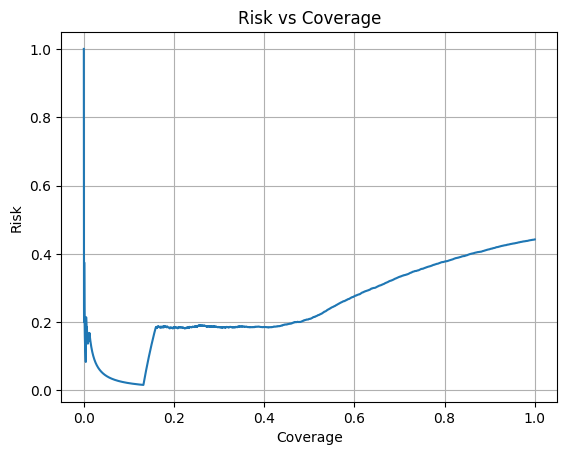

Area Under the Curve (AUC): 0.2468356867991088


In [ ]:

y_pred_probs = preds_probs[:,1]

def calculate_and_plot_risk_coverage(correct, confidence):
    # Combine the lists into a list of tuples and sort by confidence in descending order
    data = sorted(zip(confidence, correct), reverse=True)

    # Initialize counters and lists to store coverage and risk values
    correct_predictions = 0
    total_predictions = 0
    coverage_values = []
    risk_values = []

    # Loop through sorted data
    for conf, corr in data:
        total_predictions += 1
        if corr == 1:
            correct_predictions += 1

        # Calculate current risk and coverage
        risk = 1 - (correct_predictions / total_predictions)
        coverage = total_predictions / len(data)

        # Store values
        risk_values.append(risk)
        coverage_values.append(coverage)

    # Plot coverage vs risk
    plt.plot(coverage_values, risk_values)
    plt.xlabel('Coverage')
    plt.ylabel('Risk')
    plt.title('Risk vs Coverage')
    plt.grid(True)
    plt.savefig(f"plots/Bert+RF_risk_vs_coverage_{SRC_PREFIX}_{KNOWN_PREFIX}_{UNKNOWN_PREFIX}.png")
    plt.show()

    auc = np.trapz(risk_values, coverage_values)
    print("Area Under the Curve (AUC):", auc)

calculate_and_plot_risk_coverage(y_test_true, y_pred_probs)

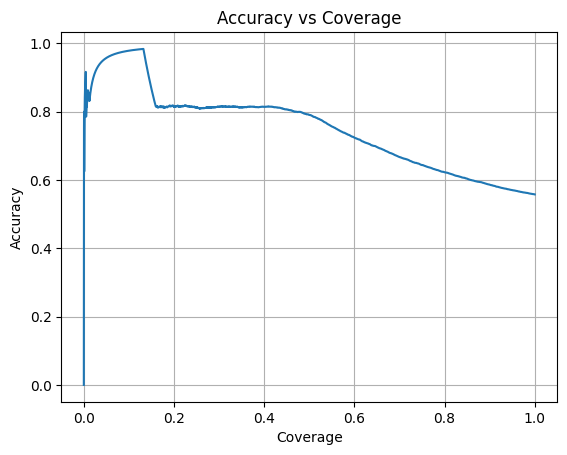

In [ ]:
def calculate_and_plot(correct, confidence):
    # Combine the lists into a list of tuples and sort by confidence in descending order
    data = sorted(zip(confidence, correct), reverse=True)

    # Initialize counters and lists to store coverage and accuracy
    correct_predictions = 0
    total_predictions = 0
    coverage_values = []
    accuracy_values = []

    # Loop through sorted data
    for conf, corr in data:
        total_predictions += 1
        if corr == 1:
            correct_predictions += 1

        # Calculate current accuracy and coverage
        accuracy = correct_predictions / total_predictions
        coverage = total_predictions / len(data)

        # Store values
        accuracy_values.append(accuracy)
        coverage_values.append(coverage)

    # Plot coverage vs accuracy
    plt.plot(coverage_values, accuracy_values)
    plt.xlabel('Coverage')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Coverage')
    plt.grid(True)
    plt.savefig(f"plots/Bert+RF_accuracy_vs_coverage_{SRC_PREFIX}_{KNOWN_PREFIX}_{UNKNOWN_PREFIX}.png")
    plt.show()
    return accuracy_values, coverage_values


acc, cov = calculate_and_plot(y_test_true, y_pred_probs)

In [ ]:
cov_at_80 = None
for a, c in zip(acc[::-1], cov[::-1]):
  if a>=0.8:
    cov_at_80 = c
    break

print(cov_at_80)

0.4715


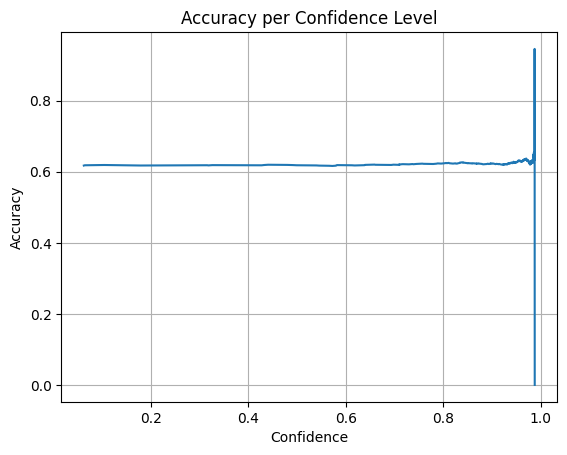

In [ ]:
y_val_true= risk_cov_val_truths.values
def calculate_and_plot_accuracy_per_confidence(correct, confidence):
    # Combine the lists into a list of tuples and sort by confidence in descending order
    data = sorted(zip(confidence, correct), reverse=True)

    # Initialize counters and lists to store confidence values and corresponding accuracy
    correct_predictions = 0
    total_predictions = 0
    confidence_values = []
    accuracy_values = []

    # Loop through sorted data
    for conf, corr in data:
        total_predictions += 1
        if corr == 1:
            correct_predictions += 1

        # Calculate current accuracy
        accuracy = correct_predictions / total_predictions

        # Store values
        confidence_values.append(conf)
        accuracy_values.append(accuracy)

    # Plot confidence vs accuracy
    plt.plot(confidence_values, accuracy_values)
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Confidence Level')
    plt.grid(True)
    plt.savefig(f"plots/Bert+RF_accuracy_per_confidence_{SRC_PREFIX}_{KNOWN_PREFIX}_{UNKNOWN_PREFIX}.png")
    plt.show()

calculate_and_plot_accuracy_per_confidence(y_val_true, y_pred_probs)


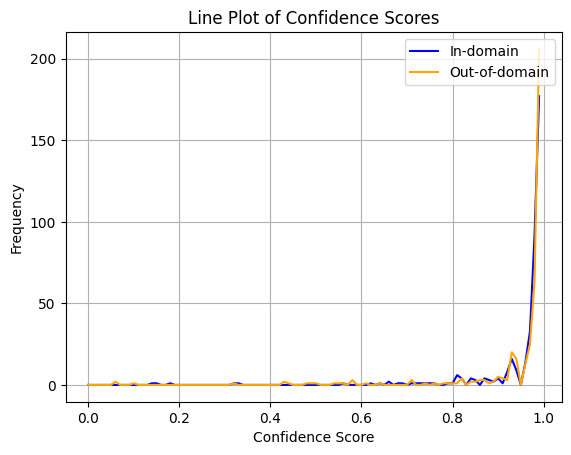

In [ ]:
def plot_confidence_histogram(domain, confidence):
    # Separate the confidence scores for in-domain and out-of-domain
    in_domain_confidence = [round(conf, 2) for conf, dom in zip(confidence, domain) if dom == 1]
    out_of_domain_confidence = [round(conf, 2) for conf, dom in zip(confidence, domain) if dom == 0]

    # Create bins
    bins = np.arange(0, 1.01, 0.01)

    # Calculate histogram for in-domain confidence
    in_domain_hist, _ = np.histogram(in_domain_confidence, bins=bins)

    # Calculate histogram for out-of-domain confidence
    out_of_domain_hist, _ = np.histogram(out_of_domain_confidence, bins=bins)

    # Plot line plot of the histogram for in-domain
    plt.plot(bins[:-1], in_domain_hist, label='In-domain', color='blue')

    # Plot line plot of the histogram for out-of-domain
    plt.plot(bins[:-1], out_of_domain_hist, label='Out-of-domain', color='orange')

    # Format the plot
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.title('Line Plot of Confidence Scores')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Show the plot
    plt.savefig(f"plots/Bert+RF_line_confidence_{SRC_PREFIX}_{KNOWN_PREFIX}_{UNKNOWN_PREFIX}.png")
    plt.show()

domain = [1]*(len(val)//2) + [0]*(len(val)//2)
plot_confidence_histogram(domain, y_pred_probs)

In [ ]:
"""
plots:
AUC vs Amount of OOD data access- NOT Now
Maxprob vs frequency
Probability of correctness vs Maxprob

Frequency vs Callibrator Probability
Probability of correctness vs callibrator probability


Table:
1) AUC, Cov@ Acc=80%, Cov@Aucc= 90%

"""

'\nplots:\nAUC vs Amount of OOD data access- NOT Now\nMaxprob vs frequency\nProbability of correctness vs Maxprob\n\nFrequency vs Callibrator Probability\nProbability of correctness vs callibrator probability\n\n\nTable:\n1) AUC, Cov@ Acc=80%, Cov@Aucc= 90%\n\n'

Distance Baseline Plots


In [ ]:
# convert train into a matrix of tokens
def create_train_matrix(data):
  train_matrix = []
  for i in range(len(data)):
    question, context = data.iloc[i]["question"], data.iloc[i]["context"]

    inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt", truncation = True, max_length=512)["input_ids"].numpy()[0]
    num_to_pad = 512 - len(inputs)
    inputs = np.pad(inputs, (0, num_to_pad), 'constant')
    train_matrix.append(inputs)

  train_matrix = np.array(train_matrix).reshape(len(data), 512)

  # first 1600 answer, else abstain
  answer_train_matrix, abstain_train_matrix = train_matrix[0:1600, :], train_matrix[1600:len(train_matrix), :]
  return answer_train_matrix, abstain_train_matrix

answer_train_matrix, abstain_train_matrix = create_train_matrix(train)

from sklearn.metrics.pairwise import cosine_similarity

def get_preds(data):
  cosine_preds = []
  for i in tqdm(range(len(data))):
    question, context = data.iloc[i]["question"], data.iloc[i]["context"]

    inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt", truncation = True, max_length=512)["input_ids"].numpy()[0]
    num_to_pad = 512 - len(inputs)
    inputs = np.pad(inputs, (0, num_to_pad), 'constant')
    inputs = np.expand_dims(inputs, axis=0)

    answer_cosine_sim = np.amax(cosine_similarity(answer_train_matrix, inputs))
    cosine_preds.append(answer_cosine_sim)


  return np.array(cosine_preds)

NameError: ignored

In [ ]:
y_test_pred_distance = get_preds(test)

In [ ]:

calculate_and_plot_risk_coverage(y_test_true, y_test_pred_distance)

In [ ]:
acc, cov = calculate_and_plot(y_test_true, y_test_pred_distance)


In [ ]:
cov_at_80 = None
for a, c in zip(acc[::-1], cov[::-1]):
  if a>=0.8:
    cov_at_80 = c
    break

print(cov_at_80)

In [ ]:
y_val_pred_distance = get_preds(val)
calculate_and_plot_accuracy_per_confidence(y_val_true, y_val_pred_distance)


## END of plots code/

In [ ]:
### 0 - answer
### 1 - abstain

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
def get_coverage(thresh):
  pred_val = []
  for p0, p1 in preds_probs:
    if p0>thresh:
      pred_val.append(0)
    else:
      pred_val.append(1)

  cntr = Counter(pred_val)
  coverage = cntr[0]/(cntr[0]+cntr[1])
  return coverage


In [ ]:
thresholds = [x/100 for x in range(0,100,4)]
coverages = []
for thresh in thresholds:
  coverages.append(get_coverage(thresh))

plt.plot(thresholds,coverages)

In [ ]:
for it in zip(thresholds, coverages):
  print(it)

Ignore code from here

In [ ]:
pred_val = []

THRESH = 0.6
for p0, p1 in preds_probs:
  if p0>THRESH:
    pred_val.append(0)
  else:
    pred_val.append(1)

cntr = Counter(pred_val)
print(f"Coverage: {cntr[0]/(cntr[0]+cntr[1])}")

In [ ]:
accuracy = accuracy_score(combined_df.ground_answers.values,combined_df.predicted_answers.values)
print(f"Accuracy: {accuracy:.2f}")

Training Calibrator

In [ ]:
X = np.asarray(combined_df.iloc[:, :12].values)
y = np.asarray([0]*1600 + [1]*400)

X_train = np.concatenate((X[:1300],X[1600:1900]))
y_train = np.concatenate((y[:1300],y[1600:1900]))
X_val = np.concatenate((X[1300:1600],X[1900:]))
y_val = np.concatenate((y[1300:1600],y[1900:]))

# shuffled_indices_train = np.random.permutation(len(X_train))
# shuffled_indices_val = np.random.permutation(len(X_val))

# X_train, y_train = X_train[shuffled_indices_train], y_train[shuffled_indices_train]
# X_val, y_val = X_val[shuffled_indices_val], y_val[shuffled_indices_val]

In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=RANDOM_SEED)
rf.fit(X_train, y_train)

In [ ]:
preds = rf.predict(X_val)
preds_probs = rf.predict_proba(X_val)

In [ ]:
pred_val = []
THRESH = 0.1
for p0, p1 in preds_probs:
  if p0>THRESH:
    pred_val.append(0)
  else:
    pred_val.append(1)

cntr = Counter(pred_val)
print(f"Coverage: {cntr[0]/(cntr[0]+cntr[1])}")

In [ ]:
def get_indices(indices):
  ret = []
  for i in indices:
    if i<=300:
      ret.append(i+1300)
    else:
      ret.append(i-300+1900)

  return ret

In [ ]:
indices = [index for index, value in enumerate(pred_val) if value == 0]
new_indices = get_indices(indices)

In [ ]:
val_answers = combined_df[['ground_answers', 'predicted_answers']].iloc[new_indices]

In [ ]:
accuracy = accuracy_score(val_answers.ground_answers.values,val_answers.predicted_answers.values)
print(f"Accuracy: {accuracy:.2f}")

In [ ]:
def acc_vs_threshold()

Don't bother about the code below!!

In [ ]:
# print(context, question)
inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt")
input_ids = inputs["input_ids"].tolist()[0]
# print(input_ids)
outputs = model(**inputs)
# print(f"Outputs: {outputs}")
start_scores = outputs.start_logits
end_scores = outputs.end_logits
print(start_scores)

all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
print(f"all tokens: {all_tokens}")
print(torch.argmax(start_scores, dim=1).item(), torch.argmax(end_scores, dim=1).item())
answer_tokens = all_tokens[torch.argmax(start_scores, dim=1).item(): torch.argmax(end_scores, dim=1).item() + 1]
print(answer_tokens)
answer = tokenizer.convert_tokens_to_string(answer_tokens)
print(answer)

In [ ]:
out = tokenizer(context, question, return_tensors = "pt")

In [ ]:
out

In [ ]:
model(**out)

In [ ]:
df = pd.read_csv("data/news_qa/train.csv")

In [ ]:
df.head()

In [ ]:
p_src